# RQ1 - Eyetracking Chord Visualizations

## Import Libs

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import utils.GenSnippetsLib as gsl
import math
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_chord_diagram import chord_diagram

## Read in The Token Based Fixation CSV

In [2]:
# import dataframe
df_token_fixation_per_participant = pd.read_csv("./data/fixation_per_participant_per_token.csv")
df_token_fixation_per_participant["TokenIdx"] = df_token_fixation_per_participant["TokenIdx"].astype(float)
df_token_fixation_per_participant.loc[df_token_fixation_per_participant["TokenIdx"] < 0, "TokenIdx"] = float("Nan")
df_token_fixation_per_participant = df_token_fixation_per_participant[df_token_fixation_per_participant["TokenIdx"].isna() == False]
Algorithms = df_token_fixation_per_participant["Algorithm"].unique()
Participants = df_token_fixation_per_participant["Participant"].unique()
Token = list(df_token_fixation_per_participant["Token"].unique())

# Create Transition Matrix
df_transition_matrix = pd.DataFrame(columns=["Algorithm", "Participant", "TransitionMatrix"])

for (algo, parti), df_group in tqdm(df_token_fixation_per_participant.groupby(["Algorithm", "Participant"])):
    if len(df_group) == 0:
        continue
    transition_matrix = np.full((len(Token), len(Token)), 0.0)
    previous_aoi = df_group["Token"].values[0]
    for next_aoi in df_group["Token"].values[1:]:
        previous_index = Token.index(previous_aoi)
        next_index = Token.index(next_aoi)
        transition_matrix[previous_index, next_index] += 1
        previous_aoi = next_aoi
    df_transition_matrix.loc[len(df_transition_matrix)] = [algo, parti, transition_matrix]

# merge df_transition with skillScore
df_skill = pd.read_csv("./data/filteredData/filtered_data.csv")
df_skill = df_skill[df_skill["IsOutlier"] == False][["Participant", "Algorithm", "SkillScore"]]
df_transition_matrix = df_transition_matrix.merge(df_skill, on=["Participant", "Algorithm"])

# get quantile of lowest 33% and highest 33%
low = df_skill["SkillScore"].quantile(1/3)
high = df_skill["SkillScore"].quantile(2/3)

# draw chord for low and for high
df_transition_matrix_low = df_transition_matrix[df_transition_matrix["SkillScore"] <= low].reset_index()
df_transition_matrix_high = df_transition_matrix[df_transition_matrix["SkillScore"] >= high].reset_index()

transition_matrix_low = np.full((len(Token), len(Token)), 0.0)
transition_matrix_high = np.full((len(Token), len(Token)), 0.0)
for idx, matrix_row in df_transition_matrix_low.iterrows():
    matrix = matrix_row["TransitionMatrix"]
    sum = matrix.sum() if matrix.sum() != 0 else 1
    matrix = matrix / (sum*0.5)
    transition_matrix_low += matrix

for idx, matrix_row in df_transition_matrix_high.iterrows():
    matrix = matrix_row["TransitionMatrix"]
    sum = matrix.sum() if matrix.sum() != 0 else 1
    matrix = matrix / (sum*0.5)
    transition_matrix_high += matrix

transition_matrix_low /= len(df_transition_matrix_low)
transition_matrix_high /= len(df_transition_matrix_high)

  0%|          | 0/1034 [00:00<?, ?it/s]

In [3]:
color_map = plt.cm.get_cmap("gist_rainbow")
color_map = [color_map(idx/len(Token)) for idx in range(len(Token))]

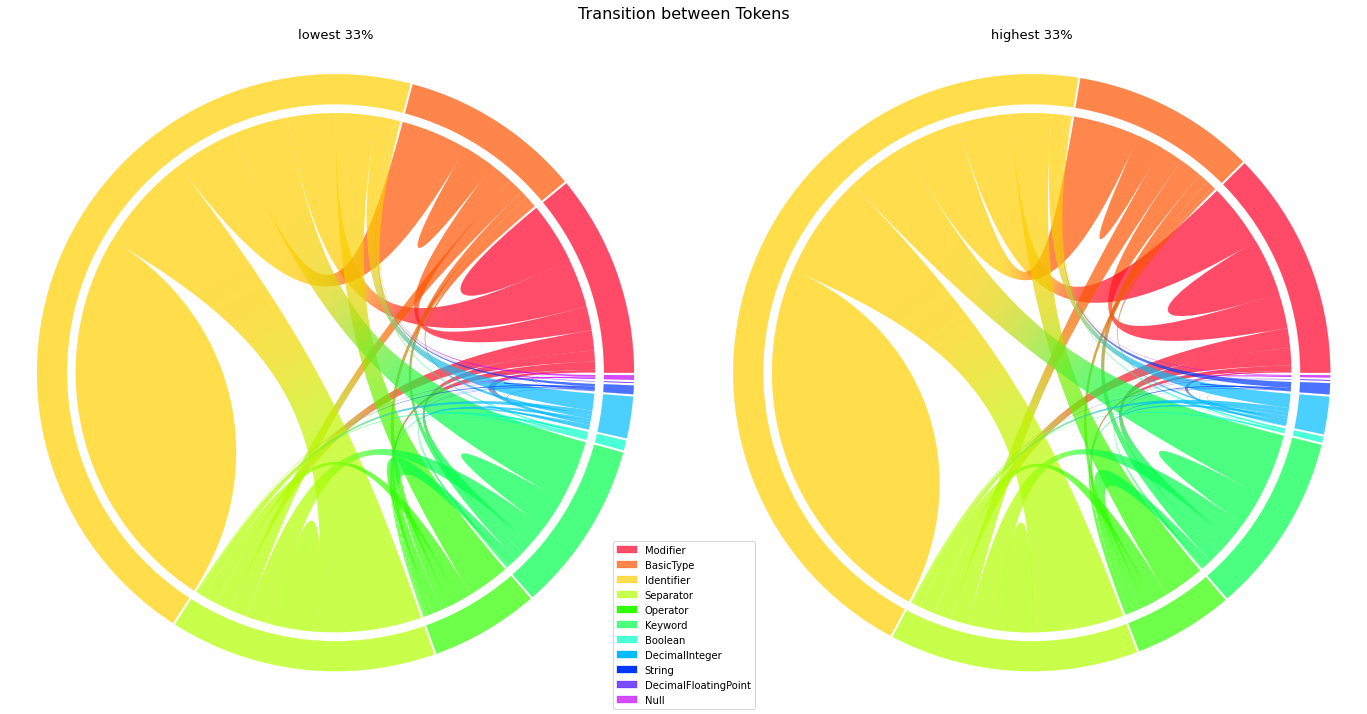

In [4]:
# draw low chord
fig, ax = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Transition between Tokens', fontsize=16)
ax[0].set_title("lowest 33%", fontsize=13)
chord_diagram(transition_matrix_low, width=0.1, pad=0.5, chordwidth=0.8, ax=ax[0], use_gradient=True, colors=color_map)

# draw the high chord
ax[1].set_title("highest 33%", fontsize=13)
chord_diagram(transition_matrix_high, width=0.1, pad=0.5, chordwidth=0.8, ax=ax[1], use_gradient=True, colors=color_map)

legend = fig.legend(Token, loc="lower center")
for idx, handle in enumerate(legend.legendHandles):
    handle.set_color(color_map[idx])

plt.show()

## Read in The AOI Based Fixation CSV

In [5]:
df_aoi_fixation_per_participant = pd.read_csv("./data/fixation_per_participant_per_aoi.csv")
df_aoi_fixation_per_participant["AOIIdx"] = df_aoi_fixation_per_participant["AOIIdx"].astype(float)
df_aoi_fixation_per_participant.loc[df_aoi_fixation_per_participant["AOIIdx"] < 0, "AOIIdx"] = float("Nan")
df_aoi_fixation_per_participant = df_aoi_fixation_per_participant[df_aoi_fixation_per_participant["AOIIdx"].isna() == False]
Algorithms = df_aoi_fixation_per_participant["Algorithm"].unique()
Participants = df_aoi_fixation_per_participant["Participant"].unique()
AOIS = list(df_aoi_fixation_per_participant["AOI"].unique())

# Create Transition Matrix
df_transition_matrix = pd.DataFrame(columns=["Algorithm", "Participant", "TransitionMatrix"])

for (algo, parti), df_group in tqdm(df_aoi_fixation_per_participant.groupby(["Algorithm", "Participant"])):
    if len(df_group) == 0:
        continue
    transition_matrix = np.full((len(AOIS), len(AOIS)), 0.0)
    previous_aoi = df_group["AOI"].values[0]
    for next_aoi in df_group["AOI"].values[1:]:
        previous_index = AOIS.index(previous_aoi)
        next_index = AOIS.index(next_aoi)
        transition_matrix[previous_index, next_index] += 1
        previous_aoi = next_aoi
    df_transition_matrix.loc[len(df_transition_matrix)] = [algo, parti, transition_matrix]

# merge df_transition with skillScore
df_skill = pd.read_csv("./data/filteredData/filtered_data.csv")
df_skill = df_skill[df_skill["IsOutlier"] == False][["Participant", "Algorithm", "SkillScore"]]
df_transition_matrix = df_transition_matrix.merge(df_skill, on=["Participant", "Algorithm"])

# get quantile of lowest 33% and highest 33%
low = df_skill["SkillScore"].quantile(1/3)
high = df_skill["SkillScore"].quantile(2/3)

# draw chord for low and for high
df_transition_matrix_low = df_transition_matrix[df_transition_matrix["SkillScore"] <= low].reset_index()
df_transition_matrix_high = df_transition_matrix[df_transition_matrix["SkillScore"] >= high].reset_index()

transition_matrix_low = np.full((len(AOIS), len(AOIS)), 0.0)
transition_matrix_high = np.full((len(AOIS), len(AOIS)), 0.0)
for idx, matrix_row in df_transition_matrix_low.iterrows():
    matrix = matrix_row["TransitionMatrix"]
    sum = matrix.sum() if matrix.sum() != 0 else 1
    matrix = matrix / (sum*0.5)
    transition_matrix_low += matrix

for idx, matrix_row in df_transition_matrix_high.iterrows():
    matrix = matrix_row["TransitionMatrix"]
    sum = matrix.sum() if matrix.sum() != 0 else 1
    matrix = matrix / (sum*0.5)
    transition_matrix_high += matrix

transition_matrix_low /= len(df_transition_matrix_low)
transition_matrix_high /= len(df_transition_matrix_high)

  0%|          | 0/1047 [00:00<?, ?it/s]

In [6]:
color_map = plt.cm.get_cmap("gist_rainbow")
color_map = [color_map(idx/len(AOIS)) for idx in range(len(AOIS))]

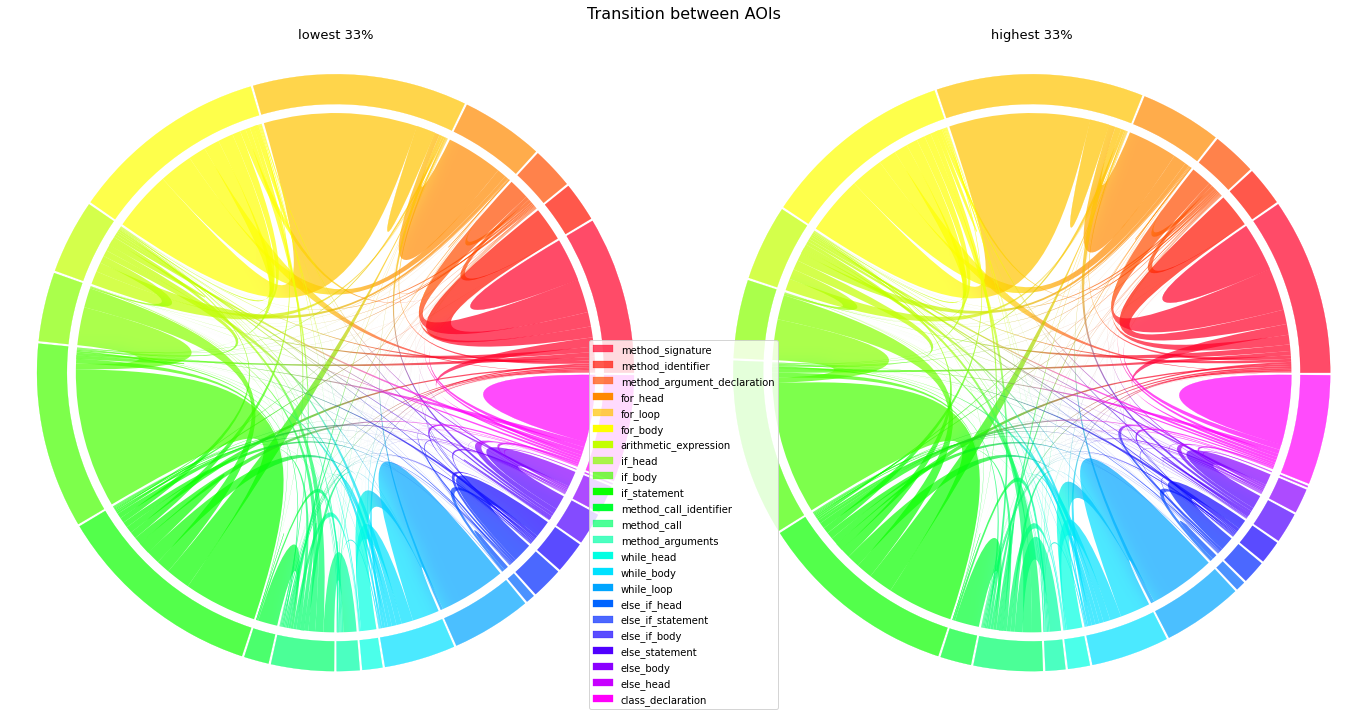

In [7]:
# draw low chord
fig, ax = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Transition between AOIs', fontsize=16)
ax[0].set_title("lowest 33%", fontsize=13)
chord_diagram(transition_matrix_low, width=0.1, pad=0.5, chordwidth=0.8, ax=ax[0], use_gradient=True, colors=color_map)

# draw the high chord
ax[1].set_title("highest 33%", fontsize=13)
chord_diagram(transition_matrix_high, width=0.1, pad=0.5, chordwidth=0.8, ax=ax[1], use_gradient=True, colors=color_map)

legend = fig.legend(AOIS, loc="lower center")
for idx, handle in enumerate(legend.legendHandles):
    handle.set_color(color_map[idx])

plt.show()

In [ ]:
# remove self transitions from matrices
